Link: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/vector-data-processing/clip-vector-data-in-python-geopandas-shapely/

In [7]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import geopandas as gpd

# Load the box module from shapely to create box objects
from shapely.geometry import box
import earthpy as et
import seaborn as sns

# Ignore warning about missing/empty geometries
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

# Adjust plot font sizes
sns.set(font_scale=1.5)
sns.set_style("white")

# Set working dir & get data
data = et.data.get_data('spatial-vector-lidar')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [8]:
# Import all of your data at the top of your notebook to keep things organized.
country_boundary_us_path = os.path.join("data", "spatial-vector-lidar", 
                                        "usa", "usa-boundary-dissolved.shp")
country_boundary_us = gpd.read_file(country_boundary_us_path)

state_boundary_us_path = os.path.join("data", "spatial-vector-lidar", 
                                      "usa", "usa-states-census-2014.shp")
state_boundary_us = gpd.read_file(state_boundary_us_path)

pop_places_path = os.path.join("data", "spatial-vector-lidar", "global", 
                               "ne_110m_populated_places_simple", "ne_110m_populated_places_simple.shp")
pop_places = gpd.read_file(pop_places_path)

# Are the data all in the same crs?
print("country_boundary_us", country_boundary_us.crs)
print("state_boundary_us", state_boundary_us.crs)
print("pop_places", pop_places.crs)

country_boundary_us epsg:4326
state_boundary_us epsg:4326
pop_places epsg:4326


In [12]:
pop_places.type

0      Point
1      Point
2      Point
3      Point
4      Point
       ...  
238    Point
239    Point
240    Point
241    Point
242    Point
Length: 243, dtype: object

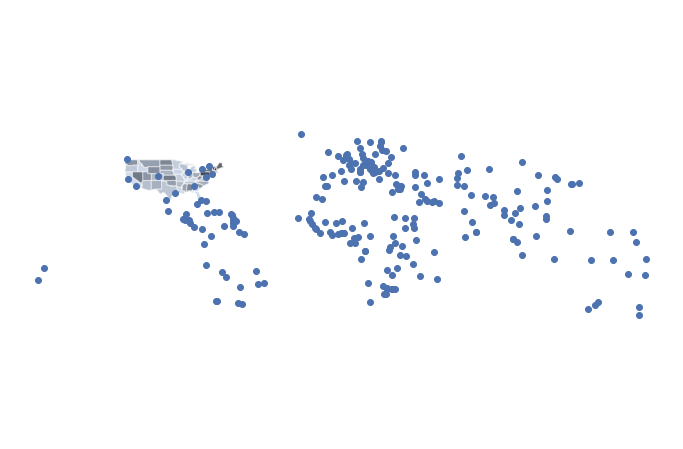

In [9]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_boundary_us.plot(alpha=.5,
                         ax=ax)

state_boundary_us.plot(cmap='Greys',
                       ax=ax,
                       alpha=.5)
pop_places.plot(ax=ax)

plt.axis('equal')
ax.set_axis_off()
plt.show()

In [4]:
# Clip the data using GeoPandas clip
points_clip = gpd.clip(pop_places, country_boundary_us)

# View the first 6 rows and a few select columns
points_clip[['name', 'geometry', 'scalerank', 'natscale', ]].head()

,name,geometry,scalerank,natscale
175,San Francisco,POINT (-122.41717 37.76920),1,300
176,Denver,POINT (-104.98596 39.74113),1,300
177,Houston,POINT (-95.34193 29.82192),1,300
178,Miami,POINT (-80.22605 25.78956),1,300
179,Atlanta,POINT (-84.40190 33.83196),1,300


<ipython-input-5-388fbc261ae3>:19: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  points_clip.apply(lambda x: ax.annotate(s=x['name'],


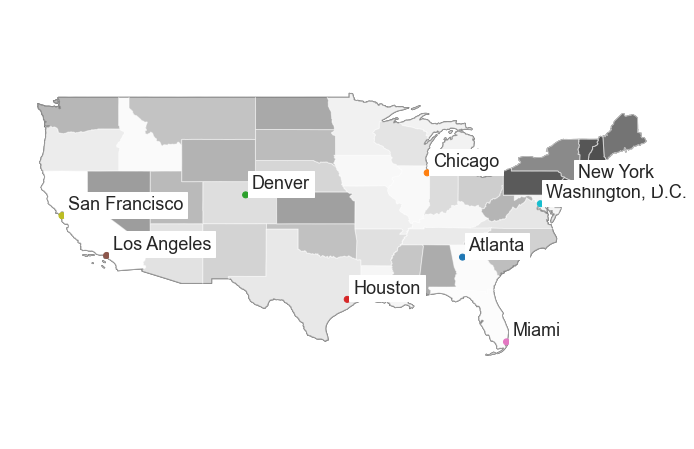

In [5]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_boundary_us.plot(alpha=1,
                         color="white",
                         edgecolor="black",
                         ax=ax)

state_boundary_us.plot(cmap='Greys',
                       ax=ax,
                       alpha=.5)

points_clip.plot(ax=ax,
                 column='name')
ax.set_axis_off()
plt.axis('equal')

# Label each point - note this is just shown here optionally but is not required for your homework
points_clip.apply(lambda x: ax.annotate(s=x['name'],
                                        xy=x.geometry.coords[0],
                                        xytext=(6, 6), textcoords="offset points",
                                        backgroundcolor="white"),
                  axis=1)
plt.show()

In [6]:
# Open the roads layer
ne_roads_path = os.path.join("data", "spatial-vector-lidar", "global", 
                             "ne_10m_roads", "ne_10m_roads.shp")
ne_roads = gpd.read_file(ne_roads_path)

# Are both layers in the same CRS?
if (ne_roads.crs == country_boundary_us.crs):
    print("Both layers are in the same crs!",
          ne_roads.crs, country_boundary_us.crs)

Both layers are in the same crs! epsg:4326 epsg:4326


In [7]:
# Simplify the geometry of the clip extent for faster processing
# Use this with caution as it modifies your data.
country_boundary_us_sim = country_boundary_us.simplify(
    .2, preserve_topology=True)

In [8]:
# Clip data
ne_roads_clip = gpd.clip(ne_roads, country_boundary_us_sim)

# Ignore missing/empty geometries
ne_roads_clip = ne_roads_clip[~ne_roads_clip.is_empty]

print("The clipped data have fewer line objects (represented by rows):",
      ne_roads_clip.shape, ne_roads.shape)

The clipped data have fewer line objects (represented by rows): (7346, 32) (56601, 32)


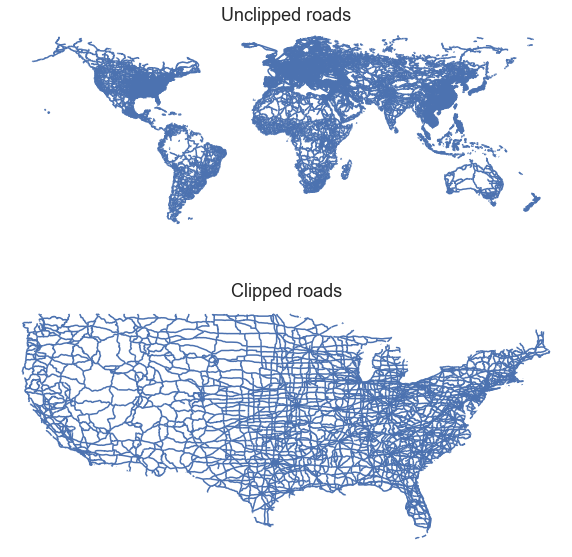

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ne_roads.plot(ax=ax1)
ne_roads_clip.plot(ax=ax2)

ax1.set_title("Unclipped roads")
ax2.set_title("Clipped roads")

ax1.set_axis_off()
ax2.set_axis_off()

plt.axis('equal')
plt.show()

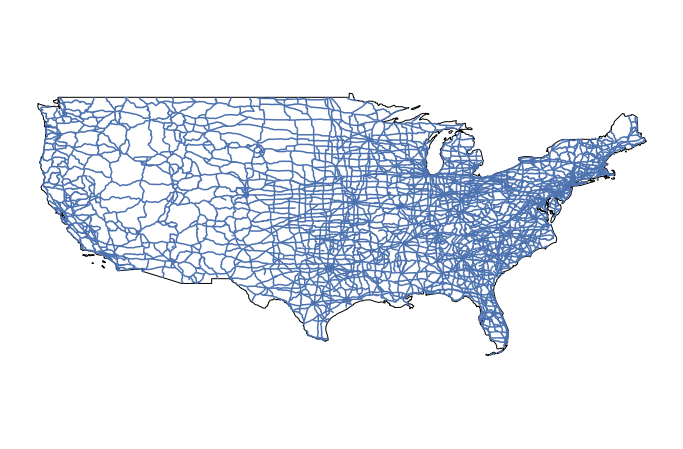

In [10]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_boundary_us.plot(alpha=1,
                         color="white",
                         edgecolor="black",
                         ax=ax)

ne_roads_clip.plot(ax=ax)

ax.set_axis_off()
plt.axis('equal')
plt.show()

How Clip() works: https://github.com/geopandas/geopandas/blob/master/geopandas/tools/clip.py

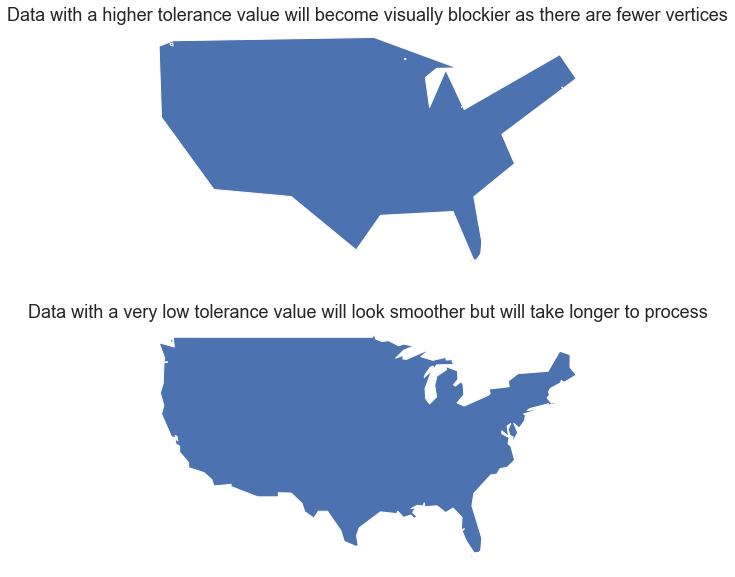

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Set a larger tolerance yields a blockier polygon
country_boundary_us.simplify(2, preserve_topology=True).plot(ax=ax1)

# Set  a larger tolerance yields a blockier polygon
country_boundary_us.simplify(.2, preserve_topology=True).plot(ax=ax2)

ax1.set_title(
    "Data with a higher tolerance value will become visually blockier as there are fewer vertices")
ax2.set_title(
    "Data with a very low tolerance value will look smoother but will take longer to process")

ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

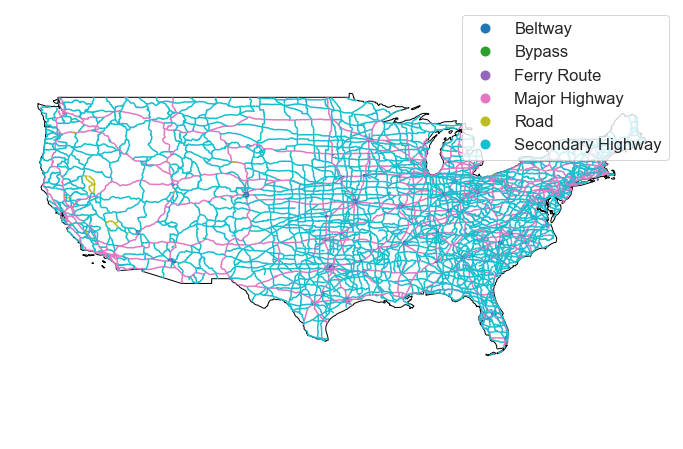

In [12]:
# Plot the data by attribute
fig, ax = plt.subplots(figsize=(12, 8))

country_boundary_us.plot(alpha=1, 
                         color="white", 
                         edgecolor="black", 
                         ax=ax)

ne_roads_clip.plot(ax=ax, 
                   column='type', 
                   legend=True)
ax.set_axis_off()
plt.axis('equal')
plt.show()

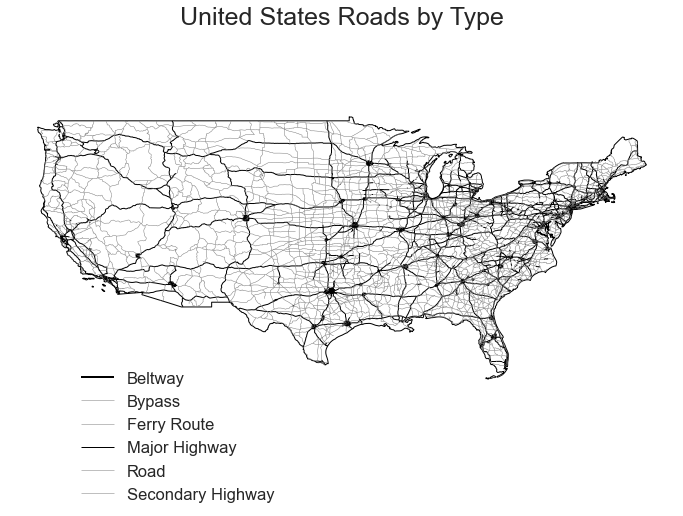

In [13]:
# Plot with a custom legend

# First, create a dictionary with the attributes of each legend item
road_attrs = {'Beltway': ['black', 2],
              'Secondary Highway': ['grey', .5],
              'Road': ['grey', .5],
              'Bypass': ['grey', .5],
              'Ferry Route': ['grey', .5],
              'Major Highway': ['black', 1]}

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

for ctype, data in ne_roads_clip.groupby('type'):
    data.plot(color=road_attrs[ctype][0],
              label=ctype,
              ax=ax,
              linewidth=road_attrs[ctype][1])

country_boundary_us.plot(alpha=1, color="white", edgecolor="black", ax=ax)

ax.legend(frameon=False, 
          loc = (0.1, -0.1))

ax.set_title("United States Roads by Type", fontsize=25)
ax.set_axis_off()

plt.axis('equal')
plt.show()